In [328]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import scipy.stats as st

import random
from scipy.optimize import curve_fit

random.seed(0)

%matplotlib widget

In [ ]:
V_s = 0.0666 # mm/ns
sigma_v = 0.001 #ns

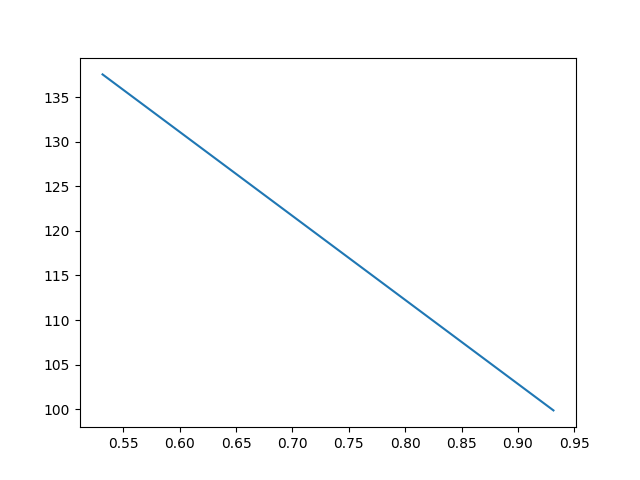

In [350]:
angle = np.radians(10)
x0 = np.random.uniform(-5,5,1)
xs = np.arange(0,3*np.tan(angle), 0.4) + x0
zs = 9 - (xs-x0)/np.tan(angle)

v_noise = V_s + np.random.normal(0,sigma_v, size=xs.shape) # noise for velocity
ts = zs / v_noise

plt.figure()
plt.plot(xs, ts)

In [ ]:
def sigma_from_ci_width(width, confidence=0.90):
    # z-score for the central confidence interval
    z = st.norm.ppf(0.5 + confidence / 2.0)
    return width / (2 * z)

In [368]:
def generate_timing(angle, noise):
    angle = np.radians(angle)
    x0 = np.random.uniform(-3,3,1)
    off = np.random.uniform(-0.4, 0.4, 1)
    xs = np.arange(off,3*np.tan(angle) + off, 0.4) + x0
    zs = 9 - (xs-x0)/np.tan(angle)

    v_noise = V_s + np.random.normal(0,sigma_v, size=xs.shape) # noise for velocity
    ts = zs / v_noise

    ts += np.random.normal(0, sigma_from_ci_width(noise), size=ts.shape) # noise for timing

    trues = (angle, x0+ 1.5 * np.tan(angle))

    return xs, ts, trues, (xs, zs)

/var/folders/p4/z5pfwnjs7x7d9zcwks7kn0j80000gn/T/ipykernel_98985/4267997217.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xs = np.arange(off,3*np.tan(angle) + off + 0.4, 0.4) + x0


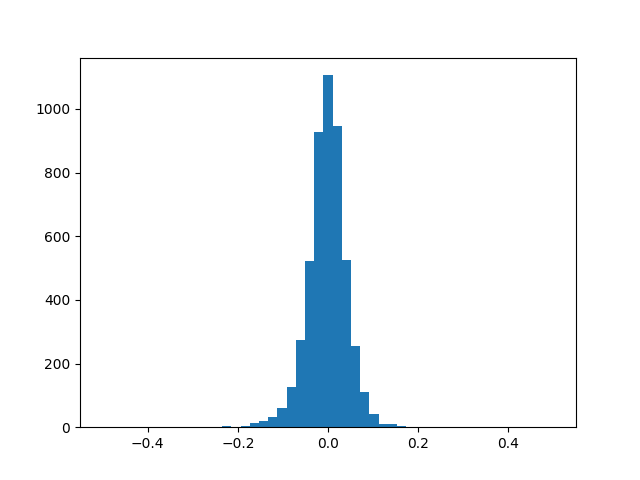

In [355]:

res_x = []
res_a = []

def reconstruct(x , y , trues, tt):

    y *= V_s

    m, b = np.polyfit(x, y, 1)

    fit = m * x + b
    r_x = ((7.5 - b) / m)

    return r_x, trues[1]

for i in range(5000):
    x, t = reconstruct(*generate_timing(5, 20))

    res_x.append(x - t)

res_x = np.array(res_x)
res_a = np.array(res_a)



plt.figure()
a = plt.hist(res_x, bins = np.linspace(-0.5,0.5,50))



/var/folders/p4/z5pfwnjs7x7d9zcwks7kn0j80000gn/T/ipykernel_98985/1973716832.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xs = np.arange(off,3*np.tan(angle) + off, 0.4) + x0


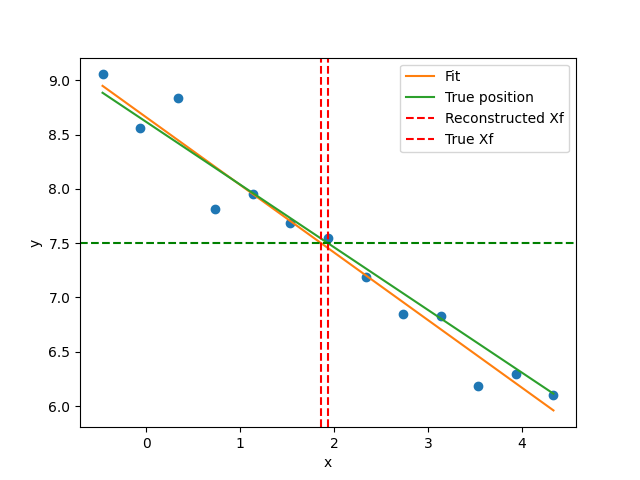

In [423]:
x , y , trues, tt = generate_timing(60, 10)

y *= V_s

m, b = np.polyfit(x, y, 1)

fit = m * x + b
r_x = ((7.5 - b) / m)

plt.figure()

plt.plot(x, y, 'o',)
plt.plot(x, fit, '-', label='Fit')
plt.plot(tt[0], tt[1], label='True position')
plt.axvline(r_x, color='r', linestyle='--', label='Reconstructed Xf')
plt.axvline(trues[1], color='r', linestyle='--', label='True Xf')
plt.axhline(7.5, color='g', linestyle='--')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

In [397]:

def gaussian(x, A, mu, sigma):
    return A * np.exp(-0.5 * ((x - mu) / sigma) ** 2)
def fit_gaussian_to_hist(stuff, bins=np.linspace(-2,2,100), density=False, show_plot=True):
    # Build histogram
    counts, edges = np.histogram(stuff, bins=bins, density=density)
    centers = 0.5 * (edges[:-1] + edges[1:])

    # Use only bins with data (avoid zero-uncertainty)
    m = counts > 0
    x = centers[m]
    y = counts[m]
    yerr = np.sqrt(y)  # Poisson uncertainties for counts
    # If density=True, Poisson errors on counts scaled by total N and bin width are a bit different.
    # For simplicity, use counts here (density=False is typical for fitting a Gaussian shape).

    # Initial guesses
    A0 = y.max()
    mu0 = np.mean(stuff)
    sigma0 = np.std(stuff, ddof=1)

    # Fit
    popt, pcov = curve_fit(
        gaussian, x, y, p0=[A0, mu0, sigma0],
        sigma=yerr, absolute_sigma=True, maxfev=10000, bounds=([0, -np.inf, 0], [ np.inf, np.inf, np.inf])
    )
    A, mu, sigma = popt
    perr = np.sqrt(np.diag(pcov))
    A_err, mu_err, sigma_err = perr

    return (mu, mu_err, sigma, sigma_err, popt, pcov)


/var/folders/p4/z5pfwnjs7x7d9zcwks7kn0j80000gn/T/ipykernel_98985/1973716832.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xs = np.arange(off,3*np.tan(angle) + off, 0.4) + x0


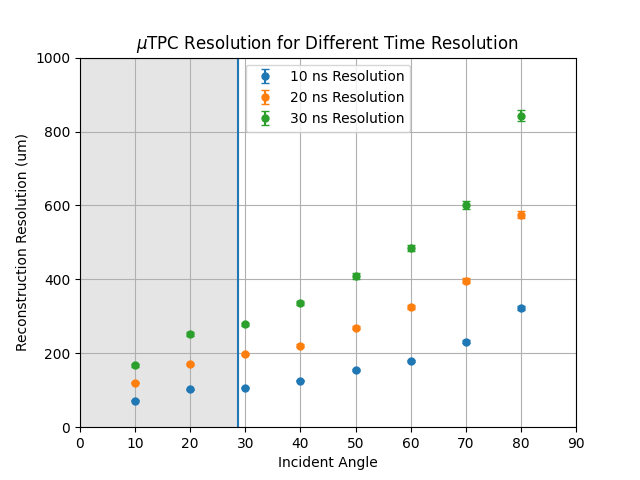

In [415]:
plt.figure()

noises = np.arange(10, 40, 10)

for n in noises:
    angles = np.arange(10,90,10)

    res = []

    err = []

    for a in angles:
        stuff = []
        for i in range(2000):
            x, t = reconstruct(*generate_timing(a, n))
            stuff.append(x - t)
        stuff = np.array(stuff)

        (mu, mu_err, sigma, sigma_err, popt, pcov) = fit_gaussian_to_hist(stuff)

        res.append(sigma)
        err.append(sigma_err)

    res = np.array(res) * 1000
    err = np.array(err) * 1000

    plt.errorbar(angles, res * 1.6, yerr=err*1.6, fmt='o', markersize=5, capsize=3, label=f'{n} ns Resolution')

plt.axvline(28.7)
plt.fill_betweenx(
    y=[-100, 1000],  # vertical range
    x1=-100, x2=28.7,
    color='gray', alpha=0.2
)

plt.xlim(0, 90)
plt.ylim(0, 1000)

plt.title('$\\mu$TPC Resolution for Different Time Resolution ')
plt.xlabel('Incident Angle')
plt.ylabel('Reconstruction Resolution (um)')
plt.grid(True)
plt.legend()

/var/folders/p4/z5pfwnjs7x7d9zcwks7kn0j80000gn/T/ipykernel_98985/1629955538.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xs = np.arange(off,3*np.tan(angle) + off + 0.4, 0.4) + x0


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

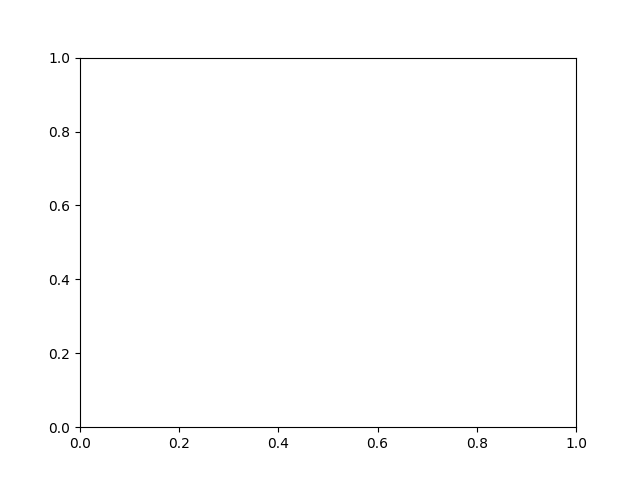

In [260]:
plt.figure()
plt.scatter(*generate_timing(50, 10))

In [ ]:
angles = np.linspace(0,80,10)
events = 100

res = []
err = []

for angle in angles:

    r = []
    for i in range(events):
        
        xs, ts = generate_timing(angle, 5)
        a, pos = fit_line(xs, ts)
        r.append(angle - a)
    res.append(np.std(r))
    err.append(np.std(r))



In [ ]:
plt.figure()
plt.errorbar(angles, res, fmt='o', label='Timing Resolution')

In [ ]:
r = []
ang = 50
for i in range(5000):

    xs, ts = generate_timing(ang, 10)
    a, pos = fit_line(xs, ts)
    r.append(ang - a)
plt.figure()
plt.hist(r, bins=30)
plt.xlabel('Timing Resolution (degrees)')